# 自分のテトリスのリプレイデータを解析する
DataCollector.ipynbで作成したテトリスのリプレイデータreplay.csvからデータ解析をしてみます
- - -

## ライブラリのインポート

In [3]:
import sys
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error

## SCVの読み込み

In [4]:
df_replay = pd.read_csv('replay.csv', index_col = False)
print(df_replay.shape)
df_replay.info()
df_replay.head()

(1567, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1567 non-null   object 
 1   人数        1567 non-null   int64  
 2   順位        1567 non-null   object 
 3   ゲームの時間    1567 non-null   object 
 4   送ったライン合計  1567 non-null   int64  
 5   APM       1567 non-null   float64
 6   日付        1567 non-null   object 
 7   (JST)     1567 non-null   object 
 8   リプレイ      1463 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 110.3+ KB


,ID,人数,順位,ゲームの時間,送ったライン合計,APM,日付,(JST),リプレイ
0,4RBY02,6,3/6,1:01.160,28,38.26,2021-07-07,00:06:17,NaN
1,1MGZ0S,6,5/6,1:01.850,28,37.83,2021-07-07,00:04:04,NaN
2,MN3IUP,5,4/5,1:24.290,31,45.56,2021-07-07,00:02:16,NaN
3,EP804Q,6,3/6,1:49.220,43,34.06,2021-07-06,23:59:33,NaN
4,6NCAAF,6,3/6,2:02.290,46,29.93,2021-07-06,23:56:57,NaN


## 必要の無いデータを削除する
- 今回はロビー対戦のみ解析するのでルーム対戦(30人未満)の対戦リプレイデータは削除します。
- また、ID列とリプレイ列は意味のない列なのでこれも削除します

In [5]:
df = df_replay.loc[df_replay["人数"] > 29, "人数":"(JST)"]
print(df.shape)
display(df.head())

(281, 7)


,人数,順位,ゲームの時間,送ったライン合計,APM,日付,(JST)
26,40,1/40,2:58.790,120,44.30,2021-07-03,22:42:04
27,42,10/42,2:21.900,91,43.97,2021-07-03,22:38:56
28,37,4/37,2:42,113,50.37,2021-07-03,22:35:51
29,41,4/41,2:46.660,92,38.88,2021-07-03,22:32:47
94,40,24/40,1:08.590,36,38.49,2021-06-24,21:47:21


# 列データを編集するための関数を定義
- position_to_rank_in関数：順位が10位以上だったらTrue、それ以下ならFalseを返します
- position_to_teto_one(s)：順位が1だったらTrue、それ以下ならFalseを返します
- position_to_ratio(s)：自分の順位を割合で示します。0.0に近いほど下位、1.0に近いほど上位です。
- gametime_to_second(s)：ゲームプレイ時間を秒単位に変換します
- date_to_experience(s)：Jstrisを初めてからの経過日数を秒単位に変換します
- JST_to_second(s)：ゲームプレイ時間を秒単位に変換します

In [6]:
def position_to_rank_in(s) :
    position, players = map(int, s.split('/'))
    return position <= 10


def position_to_teto_one(s) :
    position, players = map(int, s.split('/'))
    return position == 1


def position_to_ratio(s) :
    position, players = map(int, s.split('/'))
    return 1 - (position/players)


def gametime_to_second(s) :
    if s.count('.') :
        lst = s.split('.')
        s = lst[0]
        comma = int(lst[1])
        if comma < 100 :
            comma *= 10
    else :
        comma = 0
            
    if s.count(':') :
        lst = s.split(':')
        minute = int(lst[0])
        sec = int(lst[1])
    else :
        minute = 0
        sec = int(s)
        
    value = minute * 60 + sec + (comma / 1000)
    return value


def date_to_experience(s) :
    play_date = pd.to_datetime(s)
    first_play = pd.to_datetime("2019-10-11")
    return (play_date - first_play).total_seconds()


def JST_to_second(s) :
    hour, minute, sec = map(int, s.split(':'))
    return hour * 3600 + minute * 60 + sec

# 行の編集

In [7]:
df["RankIN"] = df['順位'].map(position_to_rank_in)
df["TETO-1"] = df['順位'].map(position_to_teto_one)
df["順位"] = df["順位"].map(position_to_ratio)
df["ゲームの時間"] = df["ゲームの時間"].map(gametime_to_second)
df["日付"] = df["日付"].map(date_to_experience)
df["(JST)"] = df["(JST)"].map(JST_to_second)
df["ElapsedTime"] = df["日付"] + df["(JST)"]
df = df.drop(columns=['日付', '(JST)'])
df = df.rename(columns= {"人数":"Player", "順位":"Position", "ゲームの時間":"GameTime", "送ったライン合計":"Lines"})

print(df.shape)
display(df.head())

(281, 8)


,Player,Position,GameTime,Lines,APM,RankIN,TETO-1,ElapsedTime
26,40,0.975000,178.79,120,44.30,True,True,54600124.0
27,42,0.761905,141.90,91,43.97,True,False,54599936.0
28,37,0.891892,162.00,113,50.37,True,False,54599751.0
29,41,0.902439,166.66,92,38.88,True,False,54599567.0
94,40,0.400000,68.59,36,38.49,False,False,53819241.0


- - -
# 解析1　APMと送ったライン合計の最大値の行を取得

In [8]:
print("APMの最大値の行：\n", df.loc[df['APM'].idxmax()])
print("\n\nライン合計の最大値の行：\n", df.loc[df['Lines'].idxmax()])

APMの最大値の行：
 ID              VEQ4HX
人数                  36
順位               25/36
ゲームの時間           46.25
送ったライン合計            46
APM              68.76
日付          2021-04-29
(JST)         17:01:26
リプレイ               ---
Name: 719, dtype: object


ライン合計の最大値の行：
 ID              MOAN00
人数                  46
順位                1/46
ゲームの時間        2:59.810
送ったライン合計           153
APM              54.72
日付          2021-04-18
(JST)         02:30:30
リプレイ               ---
Name: 835, dtype: object


- - -
# 解析2　今までのプレイ回数、及びランクインとテトワンの回数と割合の算出

In [9]:
counts = len(df)
rankin = sum(df["RankIN"])
tetoone = sum(df["TETO-1"])
print("今までのプレイ回数：", counts)
print("今までのランクインの回数：", rankin, "\t割合：", round(rankin/counts, 3))
print("今までのテトワンの回数：", tetoone, "\t割合：", round(tetoone/counts, 3))

今までのプレイ回数： 281
今までのランクインの回数： 201 	割合： 0.715
今までのテトワンの回数： 54 	割合： 0.192


- - -
# 解析3　成長度合いの可視化と数値化
APMを縦軸、Dateを横軸に取り、グラフにして解析をしてみます

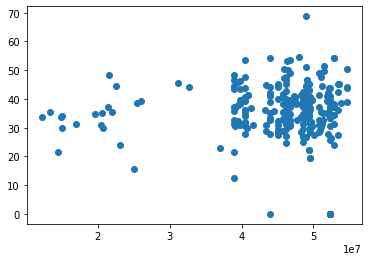

                            OLS Regression Results                            
Dep. Variable:                    APM   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.227
Date:                Wed, 04 Aug 2021   Prob (F-statistic):              0.137
Time:                        15:04:08   Log-Likelihood:                -1095.0
No. Observations:                 281   AIC:                             2194.
Df Residuals:                     279   BIC:                             2201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          40.1371      3.954     10.152      

In [10]:
X = df['ElapsedTime']
y = df['APM']
plt.scatter(X, y)
plt.show()
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

## 考察
#### グラフより、全く成長していないことが分かりました。また、回帰分析を行ってみるところ、coef - Dataの値より、マイナス成長していることが分かりました。

- - -
# 解析4　多変数な線形重回帰分析
Positionを目的変数、Player, GameTime, Lines, APM, Timeを説明変数として、線形重回帰分析を行います。

In [11]:
my_libs_dir = '../'
if not my_libs_dir in sys.path:
    sys.path.append(my_libs_dir)  # add the path to my_lib directory 

# The following lines are needed to auto-reload my library file
# Without these lines, my library file is read only once and
# modifications of my library file are not reflected.
%load_ext autoreload
%autoreload 1
%aimport my_libs.linear_reg
# import from my library file
from my_libs.linear_reg import step_aic_forward, calc_vifs

In [12]:
%config InlineBackend.figure_formats = {'png', 'retina'} #high-reso images
plt.rcParams['font.family'] = 'Yu Mincho' # for Japanese in graph (Win10)

# To show all rows and columns in the results 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [13]:
X_all = df.loc[:, ["Player", "GameTime", "Lines", "APM", "ElapsedTime"]]  # 説明変数
y = df['Position']  # objective variable
print('X_all_org:', X_all.shape)
display(X_all.head())
print('y:', y.shape)
print(y.head())

X_all_org: (281, 5)


,Player,GameTime,Lines,APM,ElapsedTime
26,40,178.79,120,44.30,54600124.0
27,42,141.90,91,43.97,54599936.0
28,37,162.00,113,50.37,54599751.0
29,41,166.66,92,38.88,54599567.0
94,40,68.59,36,38.49,53819241.0


y: (281,)
26    0.975000
27    0.761905
28    0.891892
29    0.902439
94    0.400000
Name: Position, dtype: float64


In [14]:
X_all_c = sm.add_constant(X_all)
model = sm.OLS(y, X_all_c)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Position   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     573.9
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          3.39e-143
Time:                        15:04:08   Log-Likelihood:                 368.70
No. Observations:                 281   AIC:                            -725.4
Df Residuals:                     275   BIC:                            -703.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0886      0.061     -1.443      

In [15]:
print('R2:', results.rsquared)
print('Adj R2:', results.rsquared_adj)

R2: 0.9125390882078013
Adj R2: 0.9109488898115795


In [16]:
print('p-values (F-statistic)', results.f_pvalue)

p-values (F-statistic) 3.3881649836237436e-143


In [17]:
# NOTE: after scaling, X_scaled and Y_scaled are ndarray, not DataFrame.
X_scaled = preprocessing.scale(X_all)
y_scaled = preprocessing.scale(y)
model = sm.OLS(y_scaled, X_scaled)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              575.9
Date:                Wed, 04 Aug 2021   Prob (F-statistic):                   1.01e-143
Time:                        15:04:08   Log-Likelihood:                         -56.385
No. Observations:                 281   AIC:                                      122.8
Df Residuals:                     276   BIC:                                      141.0
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [18]:
# NOTE: make DataFrames corresponding to X_scaled and y_scaled.
dfX_scaled = pd.DataFrame(X_scaled, columns=X_all.columns)
dfy_scaled = pd.Series(y_scaled, name=y.name)
exog = list(dfX_scaled.columns)  # Initial set = all explanatory variables
endog = [dfy_scaled.name]  # Objective variables
df_scaled = pd.concat([dfX_scaled, dfy_scaled], axis=1)

In [19]:
results_aic=step_aic_forward(smf.ols, exog, endog, data=df_scaled)

AIC: 799.443, formula: Position ~ 1
AIC: 801.357, formula: Position ~ Player
AIC: 494.467, formula: Position ~ Lines
AIC: 130.970, formula: Position ~ GameTime
AIC: 799.981, formula: Position ~ ElapsedTime
AIC: 648.836, formula: Position ~ APM
AIC: 132.961, formula: Position ~ GameTime + Player
AIC: 124.325, formula: Position ~ GameTime + Lines
AIC: 130.884, formula: Position ~ GameTime + ElapsedTime
AIC: 121.748, formula: Position ~ GameTime + APM
AIC: 123.547, formula: Position ~ GameTime + APM + Player
AIC: 123.589, formula: Position ~ GameTime + APM + Lines
AIC: 121.250, formula: Position ~ GameTime + APM + ElapsedTime
AIC: 122.770, formula: Position ~ GameTime + APM + ElapsedTime + Player
AIC: 123.241, formula: Position ~ GameTime + APM + ElapsedTime + Lines
The best formula: Position ~ GameTime + APM + ElapsedTime
Minimum AIC: 121.250


In [20]:
print(results_aic.aic)
print(results_aic.model.exog_names)
print(results_aic.model.endog_names)

121.24962376828023
['Intercept', 'GameTime', 'APM', 'ElapsedTime']
Position


In [21]:
endogs = results_aic.model.endog_names
exogs = results_aic.model.exog_names.copy()
exogs.remove('Intercept')
print(exogs)  # debug
X_c = sm.add_constant(X_all[exogs])
vifs = calc_vifs(X_c, y)
display(vifs)

['GameTime', 'APM', 'ElapsedTime']


,VIF
const,50.351373
GameTime,1.665769
APM,1.661306
ElapsedTime,1.011681


In [22]:
X_final_scaled = dfX_scaled[exogs]
model_final_scaled = sm.OLS(y_scaled, X_final_scaled)
results_final_scaled = model_final_scaled.fit()
print(results_final_scaled.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              965.0
Date:                Wed, 04 Aug 2021   Prob (F-statistic):                   1.32e-146
Time:                        15:04:09   Log-Likelihood:                         -56.625
No. Observations:                 281   AIC:                                      119.2
Df Residuals:                     278   BIC:                                      130.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [23]:
print(results_final_scaled.params)

GameTime       0.906335
APM            0.078438
ElapsedTime    0.028137
dtype: float64


In [24]:
print('p-values (F-statistic)', results_final_scaled.f_pvalue)

p-values (F-statistic) 1.3204822852938453e-146


In [25]:
X_final_c = sm.add_constant(X_all[exogs])
model_final = sm.OLS(y, X_final_c)
results_final = model_final.fit()
print(results_final.summary())

                            OLS Regression Results                            
Dep. Variable:               Position   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     961.6
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          4.45e-146
Time:                        15:04:09   Log-Likelihood:                 368.46
No. Observations:                 281   AIC:                            -728.9
Df Residuals:                     277   BIC:                            -714.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0547      0.028     -1.966      

## 考察
#### Player, GameTime, Lines, APM, Timeを説明変数として与えましたが、最終的には正の影響を与える列はGameTimeとAPMのみとなる結果となりました。これには2つの理由が考えられます。
#### 1つ目の理由はAPMがが高いほど、ガービッジキューに貯まったガービッジを相殺できて生き残りやすくなったので、順位が高くなったからです。 
#### 2つ目はそもそも、GameTimeが高いことは生き残った時間が長くなることなので、順位が高くなったからです。元にRankに対するGameTimeの影響度はAPMに対して圧倒的に高いです。
#### よってこれらの結果より、テトリスで上位を目指したいのならAPMを高めて積極的に攻撃していく必要はなく、最低限のテトリミノの操作でもとにかく生き残れば周りの敵が他の敵を倒してくれるので、上位を取れることが考察できます。

- - -
# 解析5　KMeansクラスタリング
APMを縦軸、順位を横軸に取り、KMeansクラスタリングをします

In [26]:
X = df.loc[:, ['Position', 'APM']]
display(X.head())

,Position,APM
26,0.975000,44.30
27,0.761905,43.97
28,0.891892,50.37
29,0.902439,38.88
94,0.400000,38.49


C:\Users\INIAD\Miniconda3\envs\cs2019_data\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "


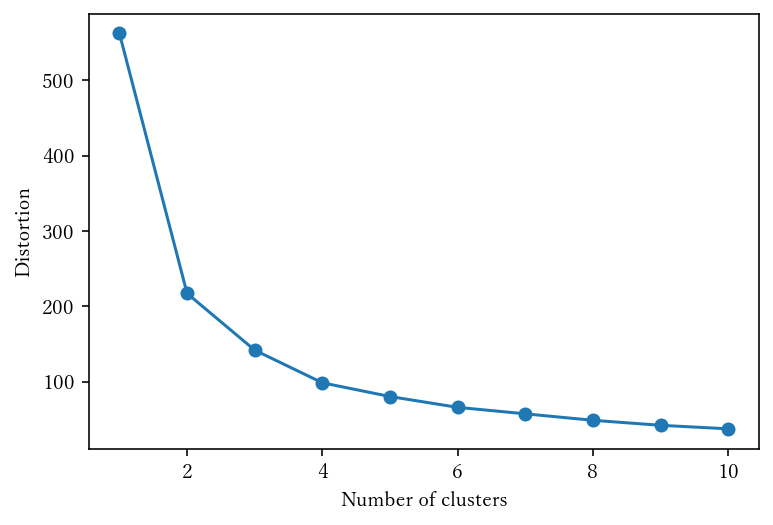

In [27]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(X_std)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [28]:
n_cls = 3
km = KMeans(n_clusters=n_cls, random_state=0)
cls = km.fit_predict(X_std)

In [29]:
print(cls)
print(pd.Series(cls).value_counts())

[0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 2 0 0 2 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 2 1 0 0 0 1 0 0 0 2 0 0 2 2 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 2 0 2 2
 0 0 0 2 0 0 0 0 2 0 2 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 2 0 0 0 0
 1 0 0 0 0 0 2 0 0 0 0 0 2 0 2 0 0 2 0 2 0 0 0 0 2 2 2 0 0 2 2 0 2 0 2 2 2
 2 2 0 0 0 0 0 0 0 0 2 0 2 2 0 0 0 2 0 0 2 2 2 1 2 0 2 0 0 2 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 2 2 0 0 0 0 2 0 0 0 2 2 1 0 0 2 0 0
 0 2 2 0 0 0 2 0 2 0 0 2 0 0 2 0 0 2 0 0 2 2 0 0 0 2 0 0 2 0 2 0 0 0 0 2 0
 1 0 2 2 0 0 1 2 2 0 0 0 2 0 2 2 0 2 2 2 2 0]
0    176
2     80
1     25
dtype: int64


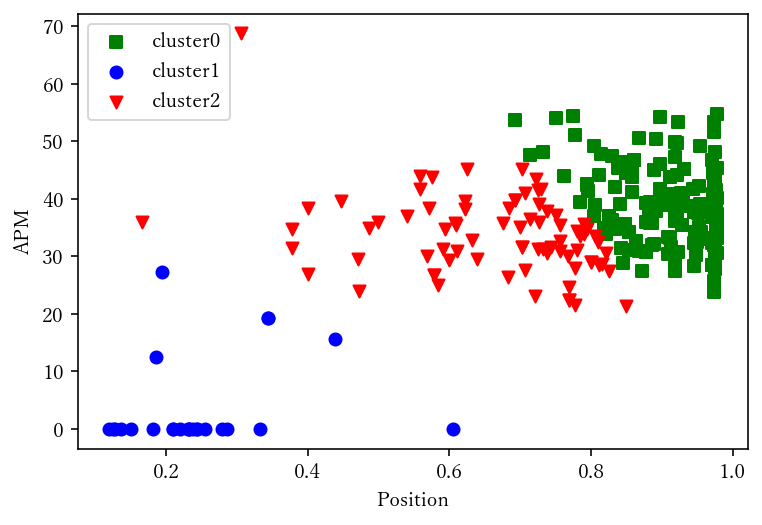

In [30]:
colors = ['green', 'blue', 'red']
markers = ['s', 'o', 'v']
for i in range(n_cls):
    df_cls = X[ cls==i ]
    plt.scatter(df_cls['Position'], df_cls['APM'],
                c=colors[i], marker=markers[i],
                label='cluster{}'.format(i))
plt.xlabel('Position')
plt.ylabel('APM')
plt.legend()
plt.show()

In [31]:
X['cluster'] = cls
display(X.groupby('cluster').mean().round(2).T)
df_cross = pd.crosstab(df['RankIN'], X['cluster'])
display(df_cross)
df_cross = pd.crosstab(df['TETO-1'], X['cluster'])
display(df_cross)
print(X[X['APM'] == 0].shape)

cluster,0,1,2
Position,0.91,0.25,0.66
APM,38.96,3.76,33.70


cluster,0,1,2
RankIN,,,
False,3,25,52
True,173,0,28


cluster,0,1,2
TETO-1,,,
False,122,25,80
True,54,0,0


(20, 3)


## 考察
#### cluster0は順位が上位かつAPMも高い特徴を持つクラスタになりました。ほぼ全てのcluster0のデータがランクインしていて、約3割のデータでテトワンを取っています。
#### cluster1は順位が低く、APMも低い特徴を持つクラスタになりました。cluster1のうち8割のデータのAPMが0です。ランクインしたデータもありません。
#### cluster2は順位が中位かつAPMが高い特徴を持つクラスタになりました。テトワンだったデータは含まれていませんが、cluster2のデータのうち約1/3がランクインしています。

- - -
# 解析6　SVMクラスタリング
RankINを目的変数、APM, Positionを説明変数として、SVMクラスタリングします。

In [32]:
X = df.loc[:, ['Position', 'APM']]
y = df['RankIN']

In [33]:
my_libs_dir = '../'
if not my_libs_dir in sys.path:
    sys.path.append(my_libs_dir)  # add the path to my_lib directory 

# The following lines are needed to auto-reload my library file
# Without these lines, my library file is read only once and
# modifications of my library file are not reflected.
%load_ext autoreload
%autoreload 1
%aimport my_libs.svm_tools
# import from my library file
from my_libs.svm_tools import plot_classification_results, plot_margin_and_sv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y)

In [35]:
sc = MinMaxScaler(feature_range=(0, 1), copy=True)
sc.fit(X_train)
X_train_std = sc.transform(X_train)

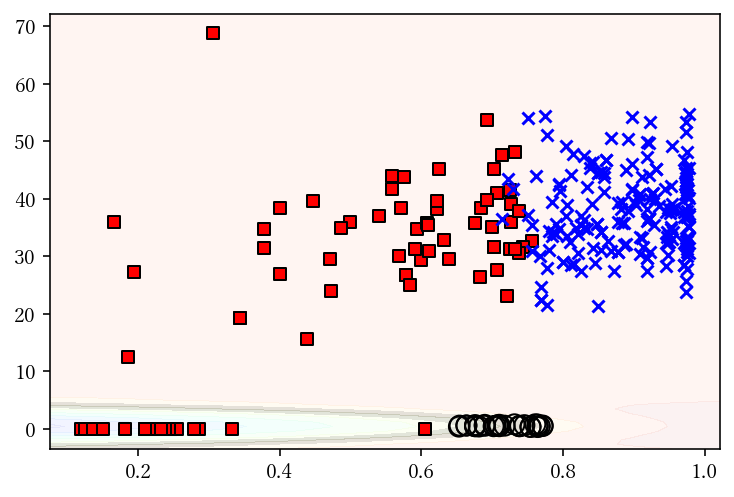

In [36]:
svc = SVC(kernel='rbf', C=100, gamma=0.1)
svc.fit(X_train_std, y_train)

plot_margin_and_sv(X.values, y.values, svc)
plt.show()

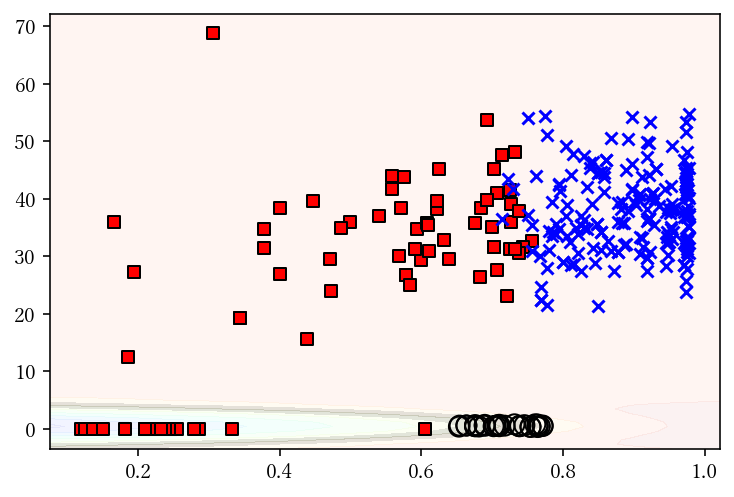

In [37]:
y_train_pred = svc.predict(X_train_std)
X_test_std = sc.transform(X_test)
y_test_pred = svc.predict(X_test_std)

plot_margin_and_sv(X.values, y.values, svc)
plt.show()

In [38]:
ct_test = pd.crosstab(y_test, y_test_pred)
display(ct_test)

TP = ct_test.iloc[1, 1]
TN = ct_test.iloc[0, 0]
FP = ct_test.iloc[0, 1]
FN = ct_test.iloc[1, 0]

print("Precision：", TP/(TP + FP))
print("Recall：", TP / (TP + FN))
print("Specificity：", TN / (TN + FP))
print("False positive rate：", FP / (FP + TN))
print("accuracy：", (TP + TN) / (TP + TN + FP + FN))

col_0,False,True
RankIN,,
False,22,2
True,1,60


Precision： 0.967741935483871
Recall： 0.9836065573770492
Specificity： 0.9166666666666666
False positive rate： 0.08333333333333333
accuracy： 0.9647058823529412


- - -
# 解析7　ランダムフォレストクラスタリング
RankINを目的変数、APM, Positionを説明変数として、ランダムフォレストクラスタリングします。

In [39]:
X = df.loc[:, ['Position', 'APM']]
y = df['RankIN']

In [40]:
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X, y)  

DecisionTreeClassifier(random_state=0)

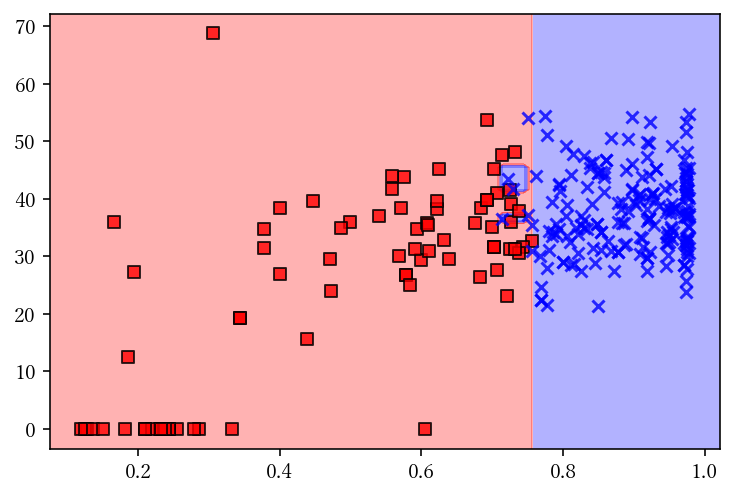

In [41]:
plot_classification_results(X.values, y.values, dtree)

## 考察
#### 基本的にはpositionの値が約0.75のところに分離超平面を引いていることが分かりました  
#### position > 約0.75に分類されたクラスタリング(青い領域)には飛び地が2つ存在することが分かりました。  

- - -
# 解析8 SVM回帰
APMを縦軸、順位を横軸に取り、SVM回帰分析をします。

In [53]:
X = df[['Position']]
y = df['APM']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [55]:
sc = MinMaxScaler(feature_range=(0, 1), copy=True)
sc.fit(X_train)
X_train_std = sc.transform(X_train)

In [56]:
C = 100.0
gamma = 'scale'
epsilon = 0.2

In [57]:
svr = SVR(gamma=gamma, C=C, epsilon=epsilon)
svr.fit(X_train_std, y_train)

SVR(C=100.0, epsilon=0.2)

In [58]:
y_train_pred = svr.predict(X_train_std)

In [59]:
X_test_std = sc.transform(X_test)
y_test_pred = svr.predict(X_test_std)

In [60]:
mse_train = mean_squared_error(y_train_pred, y_train)
print('MSE (train):', mse_train)
mse_test = mean_squared_error(y_test_pred, y_test)
print('MSE (test):', mse_test)

MSE (train): 74.27071115077231
MSE (test): 56.065659905869985


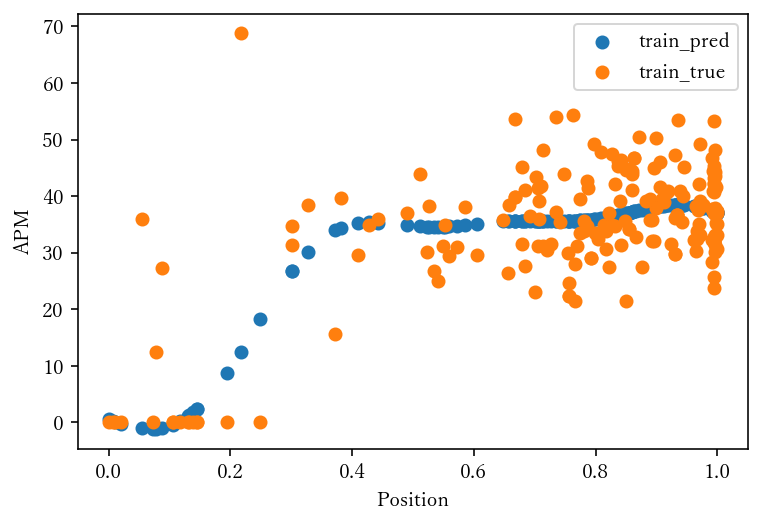

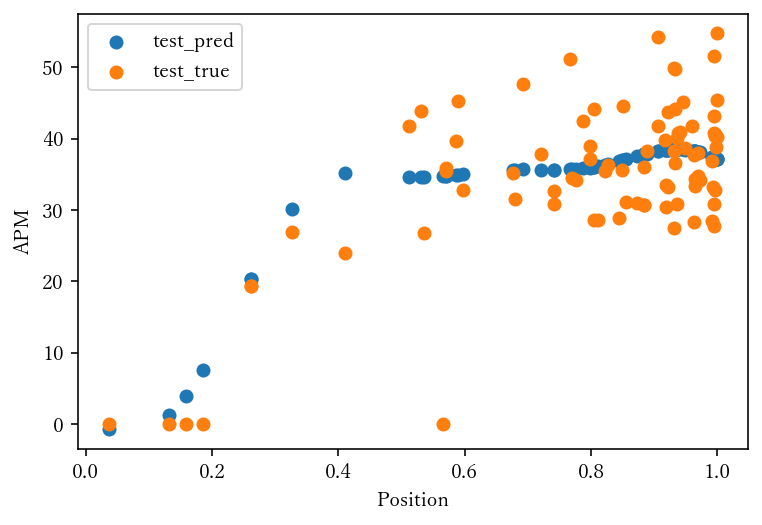

In [63]:
plt.scatter(X_train_std, y_train_pred, label='train_pred')
plt.scatter(X_train_std, y_train, label='train_true')
plt.legend()
plt.xlabel('Position')
plt.ylabel('APM')
plt.show()

plt.scatter(X_test_std, y_test_pred, label='test_pred')
plt.scatter(X_test_std, y_test, label='test_true')
plt.legend()
plt.xlabel('Position')
plt.ylabel('APM')
plt.show()

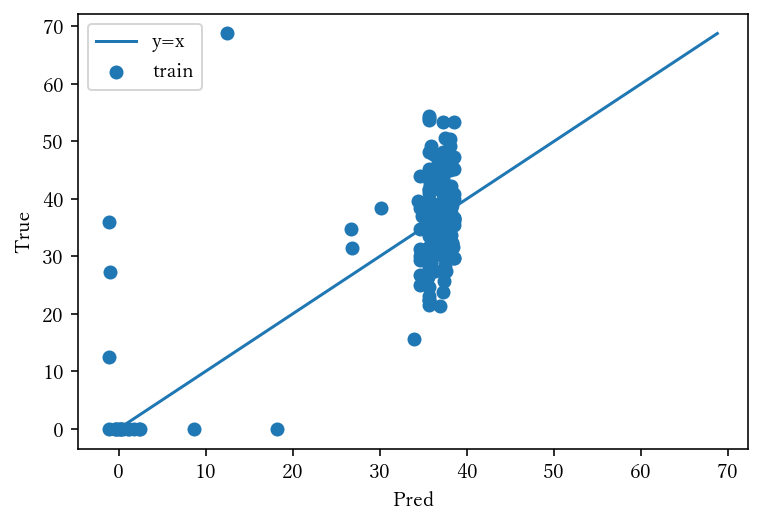

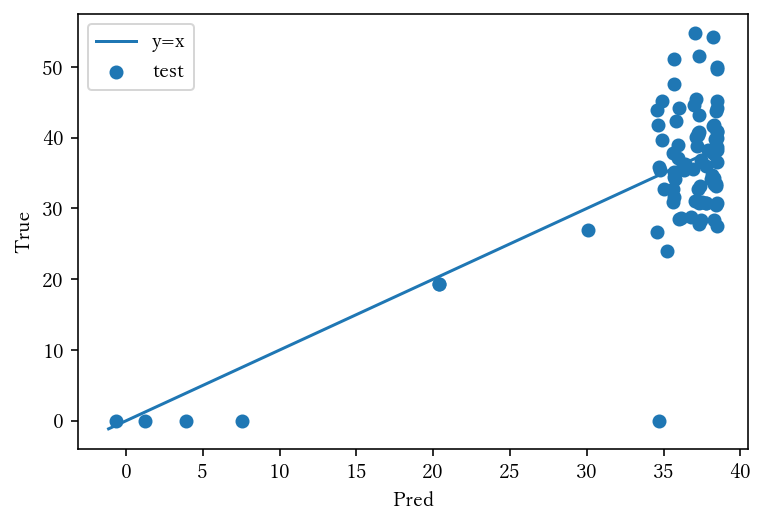

In [62]:
plt.scatter(y_train_pred, y_train, label='train')
xmin = np.array([y_train.min(), y_train.max()])
xmax = np.array([y_train.min(), y_train.max()])
plt.plot(xmin, xmax, label='y=x')
plt.xlabel('Pred')
plt.ylabel('True')
plt.legend()
plt.show()

plt.scatter(y_test_pred, y_test, label='test')
xmin = np.array([y_train_pred.min(), y_train_pred.max()])
xmax = np.array([y_train_pred.min(), y_train_pred.max()])
plt.plot(xmin, xmax, label='y=x')
plt.xlabel('Pred')
plt.ylabel('True')
plt.legend()
plt.show()

## 考察
#### APMとPositionには正の相関がありそうです。